In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocab of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
chars
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xtes,Ytes = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layers of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,n_embd), generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/ (n_embd*block_size)**0.5
#b1 = torch.randn(n_hidden, generator= g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [8]:
#hpreact.mean(0,keepdim=True)

In [9]:
#hpreact.std(0,keepdim=True)

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layers pre-activation
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 *bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999 *bnstd_running + 0.001*bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


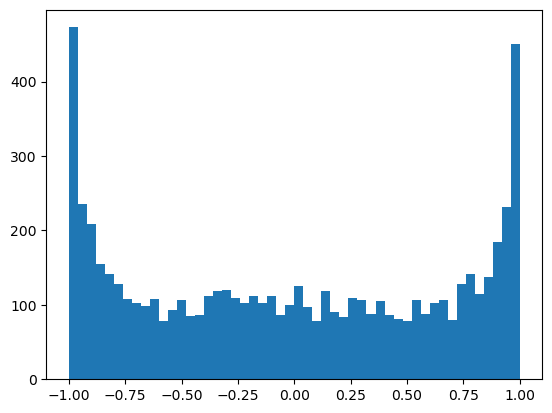

In [11]:
plt.hist(h.view(-1).tolist(),50);


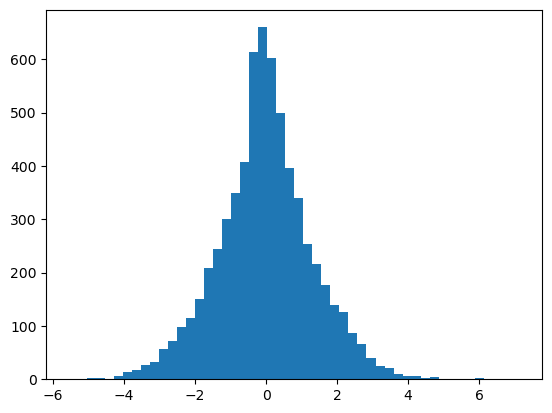

In [12]:
plt.hist(hpreact.view(-1).tolist(),50);

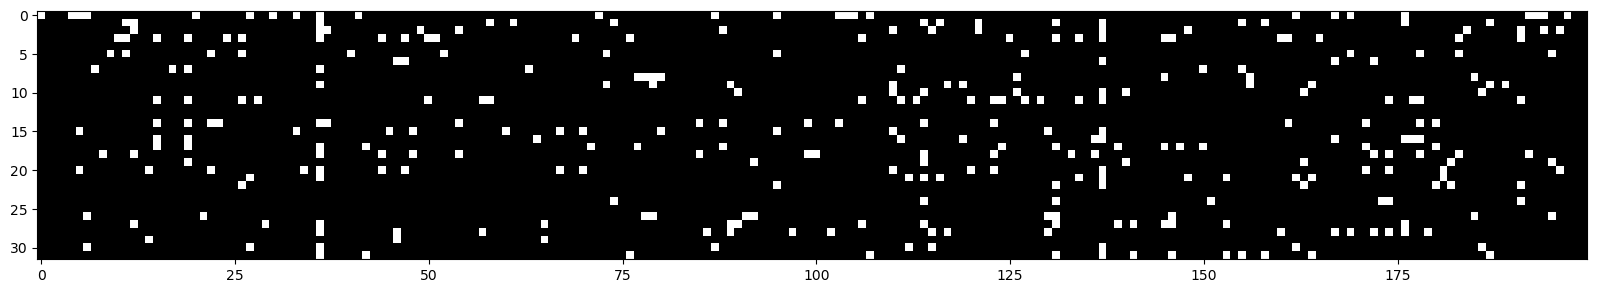

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')

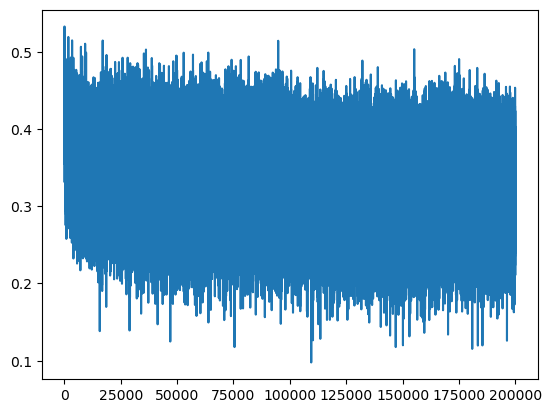

In [14]:
plt.plot(lossi)

In [15]:
# # calibrate the batch norm at the end of the training
# with torch.no_grad():
#     #pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0,keepdim=True)
#     bnstd = hpreact.std(0,keepdim=True)
    

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':{Xtr,Ytr},
        'val':{Xdev,Ydev},
        'test':{Xtes,Ytes},
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

NameError: name 'b1' is not defined

In [168]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))


briangmyah.
shel.
bdulyah.
briyasthndra.
frazshedgelisselgprdir.
kegstangelsseptz.
malkarib.
shdumrilhariest.
jadrwenniquetzulfuubdrycd.
shyldslyehs.
kayshus.
blanihal.
sadya.
suhaznjelvernert.
levishbyoss.
praddriquetz.
bdggprickslatth.
shn.
qunniest.
srffernaswalla.


#### Initialization
for each character we expect that it's probability is 1/27<br>
so the loss is - log of this probability<br>
it's 27 now


In [42]:
- torch.tensor(1/27.0).log()

tensor(3.2958)

In [53]:
# 4- dimensional example of the issue
#logits = torch.tensor([1.0,0,0,0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([7.8920e-07, 3.9464e-14, 9.5087e-17, 1.0000e+00]), tensor(36.8917))

tensor(-0.0094) tensor(0.9987)
tensor(0.0017) tensor(0.9939)


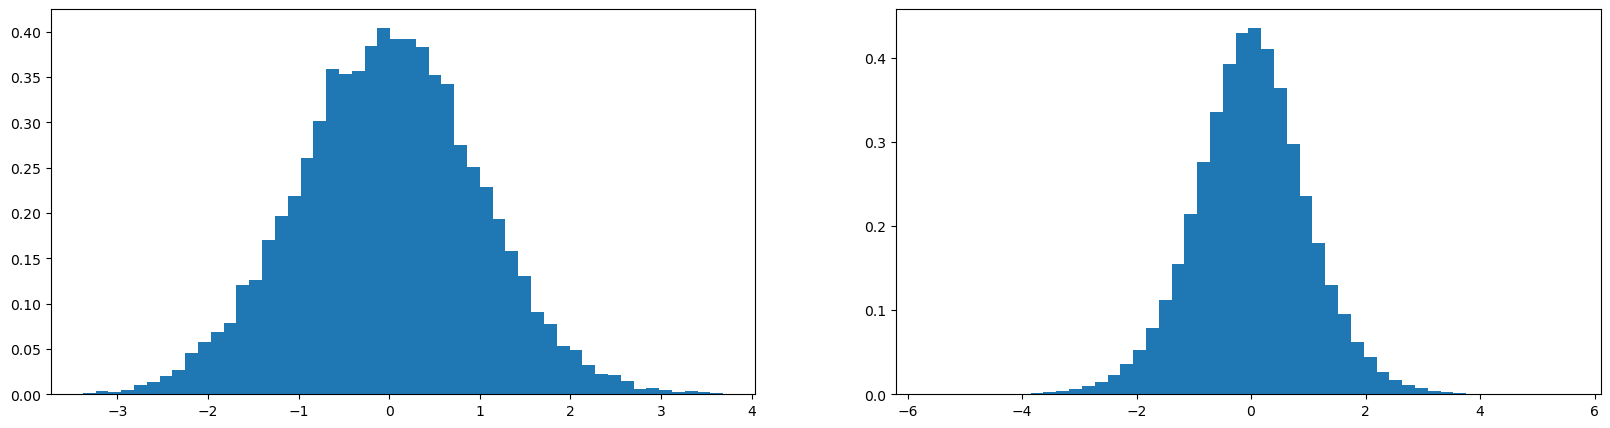

In [105]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

Init signature:
torch.nn.BatchNorm1d(
    num_features: int,
    eps: float = 1e-05,
    momentum: float = 0.1,
    affine: bool = True,
    track_running_stats: bool = True,
    device=None,
    dtype=None,
) -> None
Source:        
class BatchNorm1d(_BatchNorm):
    r"""Applies Batch Normalization over a 2D or 3D input as described in the paper
    `Batch Normalization: Accelerating Deep Network Training by Reducing
    Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

    .. math::

        y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
    of size `C` (where `C` is the number of features or channels of the input). By default, the
    elements of :math:`\gamma` are set to 1 and the elements of :math:`\beta` are set to 0. The
    standard-deviation is calculated via the biased

In [112]:
# Let's train a deeper network
class Linear:
    
    def __init__(self,fan_in,fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out),generator = g) #/ fan_in**0.5
        #self.weight = torch.zeros((fan_in,fan_out))
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out +=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self. momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim = True) # batch mean
            xvar = x.var(0,keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar+self.eps) # normalize to unit variance
        self.out = self.gamma*xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar
            return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size,n_embd), generator= g)
layers = [
    Linear(n_embd * block_size, n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    #layers[-1].weight *=0.1
    layers[-1].gamma *=0.1 
    # all other layer: apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3
    
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True
        

47551


In [113]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    # minibatch_construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0],-1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # after_debug: would take out retain graph
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 1.0#0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 ==0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])    
    if i > 1000:
        break
    

      0/ 200000:3.2870


layer 2 (      Tanh): mean +0.03, std 0.63, saturated: 4.34%
layer 5 (      Tanh): mean +0.01, std 0.62, saturated: 3.62%
layer 8 (      Tanh): mean -0.04, std 0.63, saturated: 3.06%
layer 11 (      Tanh): mean -0.01, std 0.62, saturated: 3.53%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 3.09%


Text(0.5, 1.0, 'activation distribution')

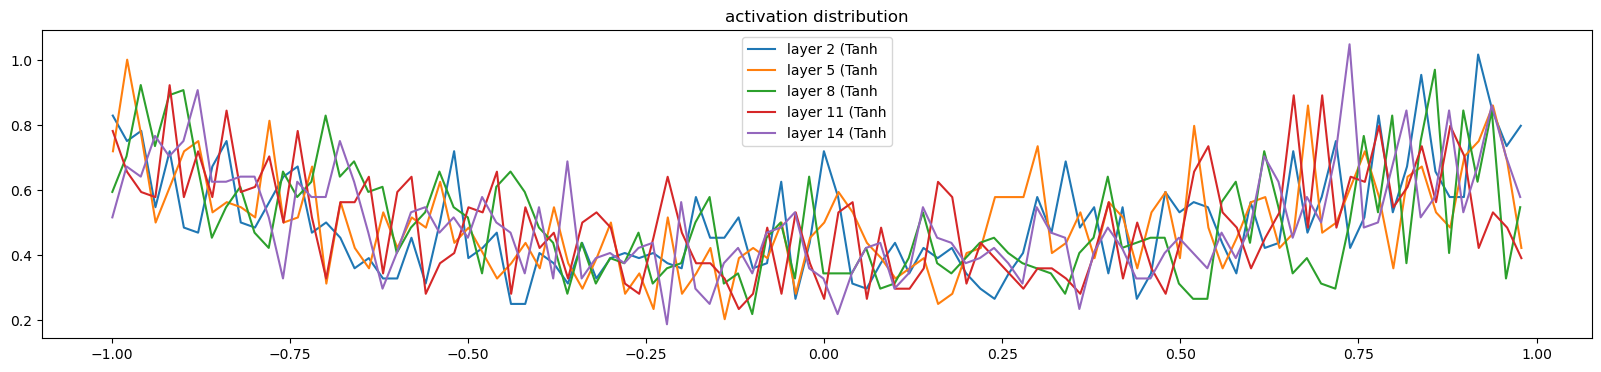

In [114]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

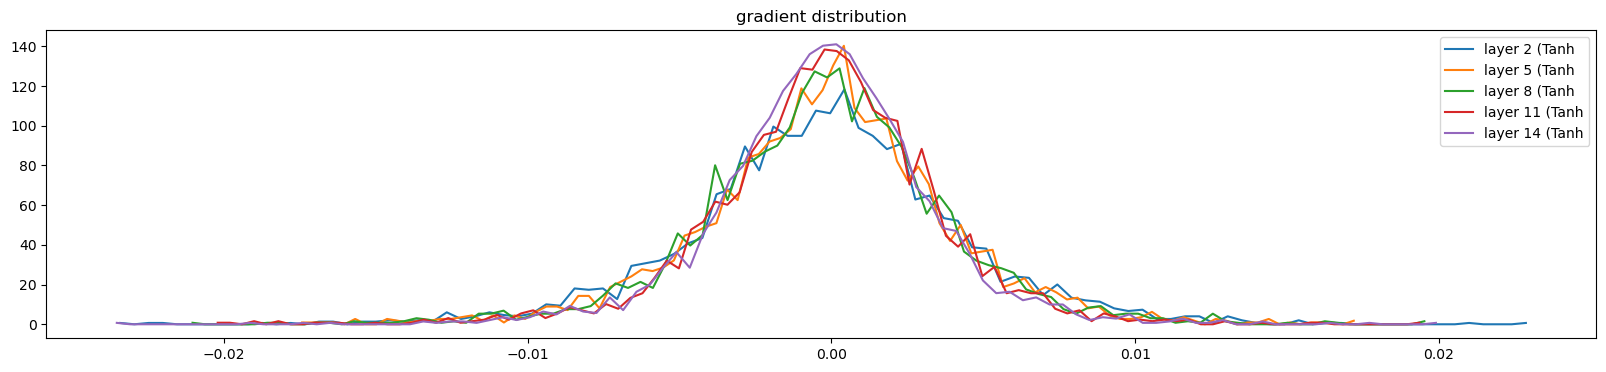

In [115]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean +0.000000 | std 8.824107e-03 | grad:data ratio 8.544464e-03
weight  (30, 100) | mean -0.000054 | std 1.673357e-03 | grad:data ratio 9.792463e-04
weight (100, 100) | mean +0.000013 | std 8.230213e-04 | grad:data ratio 4.953807e-04
weight (100, 100) | mean -0.000003 | std 7.761727e-04 | grad:data ratio 4.622847e-04
weight (100, 100) | mean +0.000006 | std 7.242641e-04 | grad:data ratio 4.331867e-04
weight (100, 100) | mean -0.000013 | std 7.080487e-04 | grad:data ratio 4.230842e-04
weight  (100, 27) | mean -0.000023 | std 1.289665e-03 | grad:data ratio 7.824800e-04


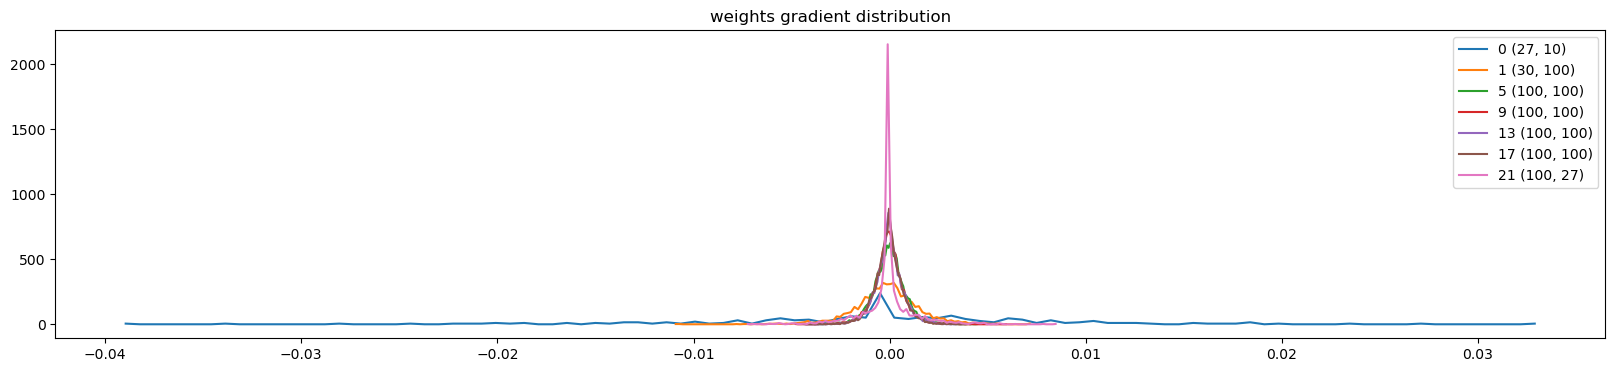

In [116]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

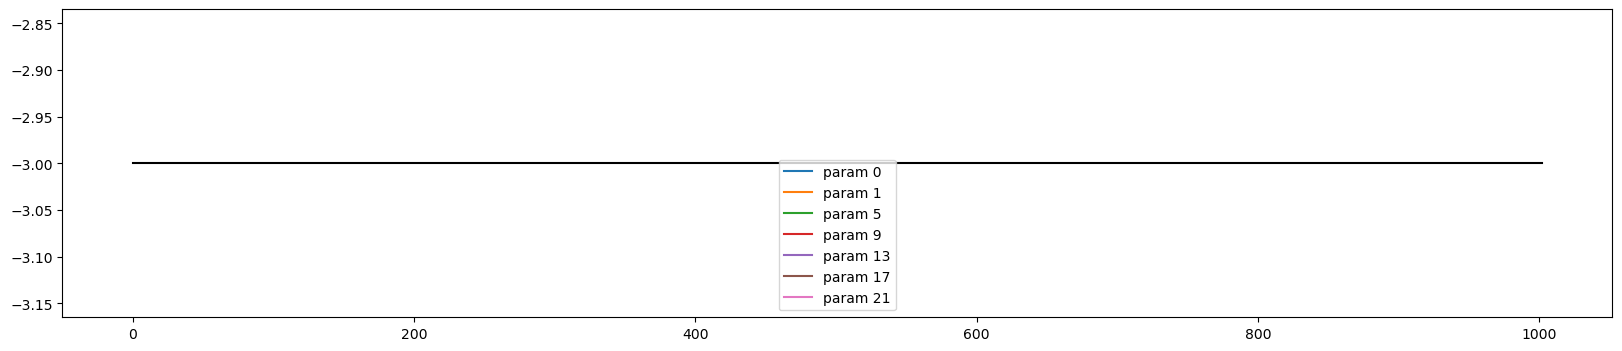

In [111]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);